## Домашнее задание №3

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [ ]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1:
Вернемся к задаче распознавания рукописных цифр, рассмотренной на первом занятии. Все также будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на пример, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 5')

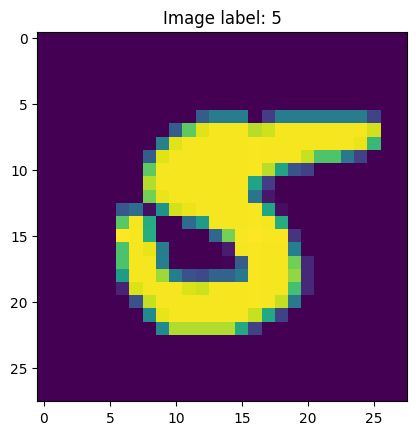

In [ ]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [ ]:
# Creating model instance
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)
        return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device) # your code here

Локальные тесты для проверки вашей модели доступны ниже:

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. В качестве примера можете воспользоваться ноутбуком с занятия №1. Также рекомендуем поработать с различными оптимизаторами.

In [ ]:
# your code here
num_epochs = 10
#batch_size = 64
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [ ]:
def train_loop(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)

    train_loss = 0
    predicted_labels = []
    real_labels = []
    #model.eval()

    for batch in train_data_loader:
        # Compute prediction and loss
        y_predicted = model(batch[0].reshape(-1, 784).to(device))
        loss = criterion(y_predicted, batch[1].to(device))

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

    return train_loss, predicted_labels, real_labels


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss = 0
    predicted_labels = []
    real_labels = []

    with torch.no_grad():
        for batch in test_data_loader:
            # Compute prediction and loss
            y_predicted = model(batch[0].reshape(-1, 784).to(device))
            loss = criterion(y_predicted, batch[1].to(device))

            test_loss += loss.item()
            predicted_labels.append(y_predicted.argmax(dim=1))
            real_labels.append(batch[1])


    test_loss /= num_batches

    print(f"Test loss: {test_loss:>8f}")

    return test_loss, predicted_labels, real_labels

In [ ]:
%%time
# for plotting
loss_history = {"train": [], "test": []}

for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss, predicted_labels, real_labels = train_loop(train_data_loader, model, criterion, optimizer)
    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()


    test_loss, predicted_labels, real_labels = test_loop(test_data_loader, model, criterion)
    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print("Done!")

Epoch 1
Train loss: 1.104830
Test loss: 0.417765
Epoch 2
Train loss: 0.365578
Test loss: 0.306241
Epoch 3
Train loss: 0.298395
Test loss: 0.269427
Epoch 4
Train loss: 0.259909
Test loss: 0.236201
Epoch 5
Train loss: 0.227513
Test loss: 0.205284
Epoch 6
Train loss: 0.201075
Test loss: 0.190800
Epoch 7
Train loss: 0.179240
Test loss: 0.165262
Epoch 8
Train loss: 0.159869
Test loss: 0.151063
Epoch 9
Train loss: 0.144918
Test loss: 0.137270
Epoch 10
Train loss: 0.130933
Test loss: 0.130670
Done!
CPU times: user 2min 21s, sys: 10.1 s, total: 2min 31s
Wall time: 3min 54s


In [ ]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.9625


In [ ]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9615



Построим график функции потерь на обучающих и на тестовых данных по эпохам:

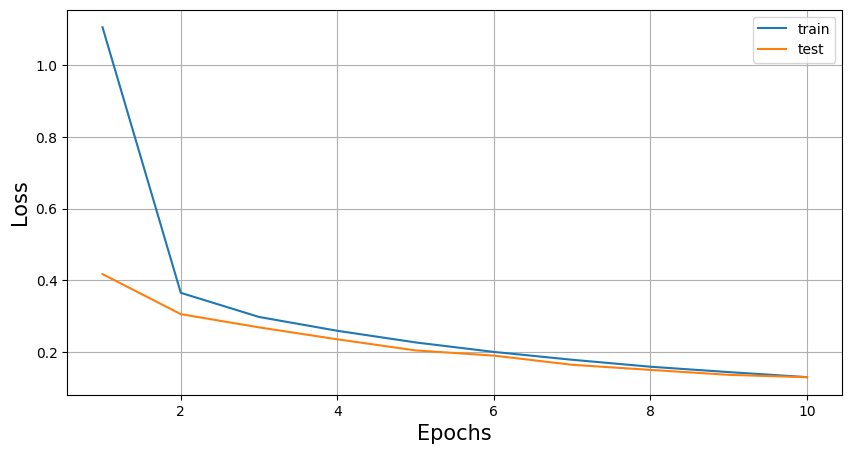

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.grid()
plt.show()

Проверка, что необходимые пороги пройдены:

In [ ]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw03_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw03_mnist/hw03_data_dict.npy

--2023-11-26 17:27:47--  https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw03_mnist/hw03_data_dict.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272438 (6.0M) [application/octet-stream]
Saving to: ‘hw03_data_dict.npy’

hw03_data_dict.npy  100%[===================>]   5.98M  21.0MB/s    in 0.3s    

2023-11-26 17:27:48 (21.0 MB/s) - ‘hw03_data_dict.npy’ saved [6272438/6272438]



In [ ]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw03_data_dict.npy'), 'Please, download `hw03_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw03_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw03.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw03.npy`')
# __________end of block__________

File saved to `submission_dict_hw03.npy`


На этом задание завершено. Поздравляем!